<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

### 1. Данные (0.5 балла)

In [84]:
# Скачайте датасет по ссылке https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing

In [85]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: total: 1.94 s
Wall time: 1.94 s



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [86]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [87]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [88]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter([word for image in captions for caption in image for word in caption ])

# Compute word frequencies for each word in captions. See code above for data structure
word_counts

Counter({'a': 978125,
         '#START#': 591435,
         '#END#': 591435,
         '.': 444651,
         'on': 215537,
         'of': 203940,
         'the': 197668,
         'in': 183933,
         'with': 154705,
         'and': 140709,
         'is': 98138,
         'man': 72984,
         'to': 68106,
         'sitting': 52880,
         'an': 49848,
         'two': 48320,
         ',': 44448,
         'at': 42703,
         'standing': 42450,
         'people': 41895,
         'are': 41060,
         'next': 37196,
         'white': 36171,
         'woman': 33934,
         'street': 30253,
         'table': 30157,
         'holding': 27952,
         'that': 27920,
         'large': 24540,
         'it': 24528,
         'person': 24402,
         'some': 24314,
         'down': 23093,
         'top': 22262,
         'group': 21585,
         'up': 20964,
         'field': 20768,
         'small': 20074,
         'tennis': 19577,
         'near': 19558,
         'front': 19501,
         

In [89]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}


In [90]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [91]:
#try it out on several descriptions of a random image
as_matrix(captions[234])

array([[   1,   24,  858,   63,   41,  140,   35,   77,   14,   24,  158,
           2,    3,    3,    3],
       [   1,   24,  858, 1486,   35,   77,   14,   24,  158,    2,    3,
           3,    3,    3,    3],
       [   1,   24,  858,   63,   41,  140,    8,   35,   77,   14,   24,
         158,   12,    2,    3],
       [   1,   24,  858,  140,   35,   77,   14,   24,  158,   58,   45,
        1487,    8,   12,    2],
       [   1,   24,  858,   41,  140,   35,   24,   54,  158,    2,    3,
           3,    3,    3,    3]], dtype=int32)

### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_value_

In [93]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors).unsqueeze(0)
        initial_hid = self.cnn_to_h0(image_vectors).unsqueeze(0)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out = self.lstm(captions_emb, (initial_hid, initial_cell))[0]

        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits

In [94]:
network = CaptionNet(n_tokens)

In [95]:
network.lstm

LSTM(128, 256, batch_first=True)

In [96]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [97]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous().reshape(-1)

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp).reshape((-1, n_tokens))

    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = nn.CrossEntropyLoss(ignore_index=3)

    return loss(logits_for_next, captions_ix_next)

In [98]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix).reshape(-1)
assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'


Добавьте ~~adam~~ ваш любимы оптимизатор для обучения.

In [99]:
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [100]:
from sklearn.model_selection import train_test_split
# captions = np.array(captions) убрал так как описания разной длины и пришлось бы закидывать куцу падов 
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [101]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image здесьь поменял потому что ранее не преобразовал в np.array --- это лист и маска не работает
    captions_for_batch_images = [captions[ind] for ind in random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)


In [102]:
generate_batch(img_codes,captions,3)

(tensor([[0.0142, 0.3362, 0.2848,  ..., 0.5539, 0.3490, 0.6948],
         [0.1558, 0.0656, 0.1528,  ..., 0.1405, 0.4512, 0.3178],
         [0.2291, 0.0914, 0.1193,  ..., 0.3243, 1.2893, 0.7083]]),
 tensor([[   1,  360,   41,    7,  101,  585,   54,  674,   15, 2887, 2845,    6,
            24,  599,   12,    2],
         [   1,   24,  195,   47,   15,  272,  328,  329,   15,   24,  640,    2,
             3,    3,    3,    3],
         [   1,   24,  262,   94,    6,  159,   14,   24,  392,  393,  193,  117,
            24,   97,   12,    2]]))

Обучайте модель на мини-батчах, как обычно. Периодически проверяйте качество на валидационном наборе.

#### **Советы**

* Если тренировочный лосс почти равен нулю или модель генерирует бессмысленный текст — проверьте, что вы предсказываете следующее слово, а не текущее или слово через два шага.

* Если модель создаёт плавные, но нерелевантные описания:

  * возможно, рекуррентная сеть не получает векторы изображения;

  * также это может быть следствием взрыва градиентов — попробуйте клиппинг или перезапуск обучения;

  * наконец, возможно, модель просто нужно обучить дольше.

* Кросс-энтропия — слабый показатель переобучения:

  * модель может переобучиться по валидационной кросс-энтропии, но при этом продолжать улучшать качество генерации;

  * используйте ручную оценку или автоматические метрики, такие как CIDEr или BLEU.

* Рекомендуется периодически проверять сеть с помощью блока “apply trained model” — можно остановить обучение, протестировать несколько примеров и продолжить.

* Типичные значения функции потерь: около 3–5, если усреднять по времени,
или масштабировать по длине при суммировании. Разумные подписи начинают появляться при лоссе 2.8–3.0.

In [122]:
batch_size = 50  # adjust me
n_epochs = 75  # adjust me
n_batches_per_epoch = 100  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [123]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))


        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        clip_grad_value_(network.parameters(), clip_value=10)
        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 100/100 [00:11<00:00,  8.39it/s]



Epoch: 0, train loss: 2.6433171463012695, val loss: 2.7324766159057616


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]



Epoch: 1, train loss: 2.6274136400222776, val loss: 2.50913143157959


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]



Epoch: 2, train loss: 2.6300050902366636, val loss: 2.625004529953003


100%|██████████| 100/100 [00:11<00:00,  8.40it/s]



Epoch: 3, train loss: 2.6417610573768617, val loss: 2.675669956207275


100%|██████████| 100/100 [00:11<00:00,  8.46it/s]



Epoch: 4, train loss: 2.585760226249695, val loss: 2.674149227142334


100%|██████████| 100/100 [00:11<00:00,  8.63it/s]



Epoch: 5, train loss: 2.5817743945121765, val loss: 2.5235185623168945


100%|██████████| 100/100 [00:11<00:00,  8.47it/s]



Epoch: 6, train loss: 2.5940522527694703, val loss: 2.5589625358581545


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]



Epoch: 7, train loss: 2.584755871295929, val loss: 2.6339914321899416


100%|██████████| 100/100 [00:11<00:00,  8.73it/s]



Epoch: 8, train loss: 2.586536161899567, val loss: 2.7555025100708006


100%|██████████| 100/100 [00:11<00:00,  8.75it/s]



Epoch: 9, train loss: 2.559972550868988, val loss: 2.665366458892822


100%|██████████| 100/100 [00:11<00:00,  8.66it/s]



Epoch: 10, train loss: 2.5680363965034485, val loss: 2.6760753631591796


100%|██████████| 100/100 [00:11<00:00,  8.51it/s]



Epoch: 11, train loss: 2.565537815093994, val loss: 2.5039079666137694


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]



Epoch: 12, train loss: 2.5634921765327454, val loss: 2.6884209156036376


100%|██████████| 100/100 [00:12<00:00,  8.23it/s]



Epoch: 13, train loss: 2.599884068965912, val loss: 2.600455617904663


100%|██████████| 100/100 [00:11<00:00,  8.69it/s]



Epoch: 14, train loss: 2.5576360201835633, val loss: 2.581567096710205


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]



Epoch: 15, train loss: 2.563611886501312, val loss: 2.664156198501587


100%|██████████| 100/100 [00:11<00:00,  8.68it/s]



Epoch: 16, train loss: 2.550590124130249, val loss: 2.5959036350250244


100%|██████████| 100/100 [00:11<00:00,  8.53it/s]



Epoch: 17, train loss: 2.5652617740631105, val loss: 2.5529356002807617


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]



Epoch: 18, train loss: 2.563804814815521, val loss: 2.6444243431091308


100%|██████████| 100/100 [00:10<00:00,  9.10it/s]



Epoch: 19, train loss: 2.558682243824005, val loss: 2.5919637203216555


100%|██████████| 100/100 [00:11<00:00,  8.83it/s]



Epoch: 20, train loss: 2.546654818058014, val loss: 2.564785623550415


100%|██████████| 100/100 [00:11<00:00,  8.99it/s]



Epoch: 21, train loss: 2.531226279735565, val loss: 2.4963940143585206


100%|██████████| 100/100 [00:11<00:00,  8.73it/s]



Epoch: 22, train loss: 2.53551885843277, val loss: 2.5115707397460936


100%|██████████| 100/100 [00:11<00:00,  8.91it/s]



Epoch: 23, train loss: 2.5468009662628175, val loss: 2.5102582931518556


100%|██████████| 100/100 [00:11<00:00,  8.52it/s]



Epoch: 24, train loss: 2.5335246610641478, val loss: 2.620949125289917


100%|██████████| 100/100 [00:11<00:00,  8.91it/s]



Epoch: 25, train loss: 2.51758216381073, val loss: 2.5996602058410643


100%|██████████| 100/100 [00:11<00:00,  8.98it/s]



Epoch: 26, train loss: 2.5341192436218263, val loss: 2.5033892154693604


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]



Epoch: 27, train loss: 2.5309967517852785, val loss: 2.611930274963379


100%|██████████| 100/100 [00:11<00:00,  8.61it/s]



Epoch: 28, train loss: 2.5170541071891783, val loss: 2.6957880020141602


100%|██████████| 100/100 [00:11<00:00,  8.92it/s]



Epoch: 29, train loss: 2.5420711970329286, val loss: 2.4320769786834715


100%|██████████| 100/100 [00:11<00:00,  8.67it/s]



Epoch: 30, train loss: 2.522887394428253, val loss: 2.599643850326538


100%|██████████| 100/100 [00:11<00:00,  9.01it/s]



Epoch: 31, train loss: 2.5088999581336977, val loss: 2.6022576808929445


100%|██████████| 100/100 [00:11<00:00,  8.78it/s]



Epoch: 32, train loss: 2.5095556640625, val loss: 2.6835652351379395


100%|██████████| 100/100 [00:12<00:00,  8.25it/s]



Epoch: 33, train loss: 2.4820007061958314, val loss: 2.4234336853027343


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]



Epoch: 34, train loss: 2.4838071417808534, val loss: 2.5802119731903077


100%|██████████| 100/100 [00:11<00:00,  8.41it/s]



Epoch: 35, train loss: 2.519745388031006, val loss: 2.5292623043060303


100%|██████████| 100/100 [00:11<00:00,  9.05it/s]



Epoch: 36, train loss: 2.505633089542389, val loss: 2.44072265625


100%|██████████| 100/100 [00:11<00:00,  8.87it/s]



Epoch: 37, train loss: 2.4739208722114565, val loss: 2.562120246887207


100%|██████████| 100/100 [00:11<00:00,  8.95it/s]



Epoch: 38, train loss: 2.5142999958992003, val loss: 2.4892579078674317


100%|██████████| 100/100 [00:11<00:00,  9.08it/s]



Epoch: 39, train loss: 2.4755633640289307, val loss: 2.447926568984985


100%|██████████| 100/100 [00:11<00:00,  8.95it/s]



Epoch: 40, train loss: 2.4764294743537905, val loss: 2.642778730392456


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]



Epoch: 41, train loss: 2.472836081981659, val loss: 2.5554558753967287


100%|██████████| 100/100 [00:10<00:00,  9.14it/s]



Epoch: 42, train loss: 2.474721040725708, val loss: 2.492804431915283


100%|██████████| 100/100 [00:11<00:00,  8.83it/s]



Epoch: 43, train loss: 2.462109611034393, val loss: 2.5083276271820067


100%|██████████| 100/100 [00:11<00:00,  9.05it/s]



Epoch: 44, train loss: 2.491150588989258, val loss: 2.6426464080810548


100%|██████████| 100/100 [00:11<00:00,  9.02it/s]



Epoch: 45, train loss: 2.4728924155235292, val loss: 2.6182549476623533


100%|██████████| 100/100 [00:11<00:00,  9.03it/s]



Epoch: 46, train loss: 2.4775188159942627, val loss: 2.6912450313568117


100%|██████████| 100/100 [00:11<00:00,  9.08it/s]



Epoch: 47, train loss: 2.472504799365997, val loss: 2.532188367843628


100%|██████████| 100/100 [00:11<00:00,  8.79it/s]



Epoch: 48, train loss: 2.499019134044647, val loss: 2.4264269828796388


100%|██████████| 100/100 [00:10<00:00,  9.21it/s]



Epoch: 49, train loss: 2.479218428134918, val loss: 2.584466648101807


100%|██████████| 100/100 [00:11<00:00,  9.09it/s]



Epoch: 50, train loss: 2.4845561456680296, val loss: 2.4603409290313722


100%|██████████| 100/100 [00:11<00:00,  8.91it/s]



Epoch: 51, train loss: 2.4975591778755186, val loss: 2.4915538311004637


100%|██████████| 100/100 [00:10<00:00,  9.10it/s]



Epoch: 52, train loss: 2.461267499923706, val loss: 2.4501863956451415


100%|██████████| 100/100 [00:11<00:00,  8.77it/s]



Epoch: 53, train loss: 2.4722347187995912, val loss: 2.6207202911376952


100%|██████████| 100/100 [00:10<00:00,  9.29it/s]



Epoch: 54, train loss: 2.4262720847129824, val loss: 2.4940951347351072


100%|██████████| 100/100 [00:10<00:00,  9.23it/s]



Epoch: 55, train loss: 2.4403684663772585, val loss: 2.5395110607147218


100%|██████████| 100/100 [00:10<00:00,  9.13it/s]



Epoch: 56, train loss: 2.4578357458114626, val loss: 2.560388946533203


100%|██████████| 100/100 [00:11<00:00,  8.99it/s]



Epoch: 57, train loss: 2.4527387022972107, val loss: 2.5478211402893067


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]



Epoch: 58, train loss: 2.4568870997428895, val loss: 2.527867078781128


100%|██████████| 100/100 [00:11<00:00,  8.90it/s]



Epoch: 59, train loss: 2.4499131655693054, val loss: 2.4682770729064942


100%|██████████| 100/100 [00:10<00:00,  9.38it/s]



Epoch: 60, train loss: 2.4327500367164614, val loss: 2.408248043060303


100%|██████████| 100/100 [00:10<00:00,  9.19it/s]



Epoch: 61, train loss: 2.4438413047790526, val loss: 2.489036464691162


100%|██████████| 100/100 [00:11<00:00,  9.03it/s]



Epoch: 62, train loss: 2.4218497323989867, val loss: 2.5759758949279785


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]



Epoch: 63, train loss: 2.4510526204109193, val loss: 2.4036696434020994


100%|██████████| 100/100 [00:11<00:00,  9.08it/s]



Epoch: 64, train loss: 2.4337725377082826, val loss: 2.532848262786865


100%|██████████| 100/100 [00:11<00:00,  9.06it/s]



Epoch: 65, train loss: 2.4232797050476074, val loss: 2.4937112808227537


100%|██████████| 100/100 [00:10<00:00,  9.27it/s]



Epoch: 66, train loss: 2.454647967815399, val loss: 2.549685478210449


100%|██████████| 100/100 [00:10<00:00,  9.33it/s]



Epoch: 67, train loss: 2.4439968347549437, val loss: 2.502252626419067


100%|██████████| 100/100 [00:10<00:00,  9.14it/s]



Epoch: 68, train loss: 2.4340414810180664, val loss: 2.5099353790283203


100%|██████████| 100/100 [00:10<00:00,  9.27it/s]



Epoch: 69, train loss: 2.4321590280532837, val loss: 2.4363483428955077


100%|██████████| 100/100 [00:10<00:00,  9.37it/s]



Epoch: 70, train loss: 2.432950322628021, val loss: 2.488054609298706


100%|██████████| 100/100 [00:10<00:00,  9.12it/s]



Epoch: 71, train loss: 2.409418284893036, val loss: 2.54632625579834


100%|██████████| 100/100 [00:10<00:00,  9.15it/s]



Epoch: 72, train loss: 2.451142294406891, val loss: 2.4428290843963625


100%|██████████| 100/100 [00:11<00:00,  8.96it/s]



Epoch: 73, train loss: 2.439618475437164, val loss: 2.5591712474822996


100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


Epoch: 74, train loss: 2.436863670349121, val loss: 2.5754075050354004
Finished!


### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [124]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [125]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t)

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

In [126]:
from matplotlib import pyplot as plt
from skimage.transform import resize
%matplotlib inline

#sample image
# !wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299))

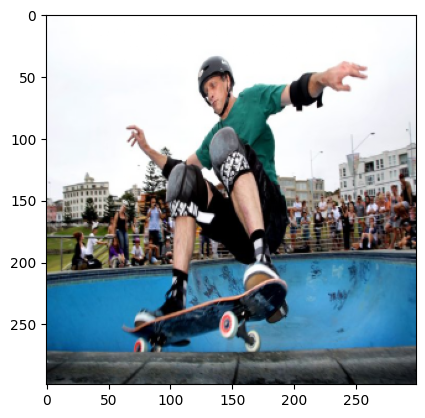

In [127]:
plt.imshow(img)

In [128]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard down a ramp .
a man on a skateboard doing a trick on a ramp .
a man on a skateboard is doing a trick .
a man on a skateboard doing a trick on a skateboard .
a man is doing a trick on a skateboard .
a man riding a skateboard down a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on a ramp .
a guy doing a trick on a skateboard .


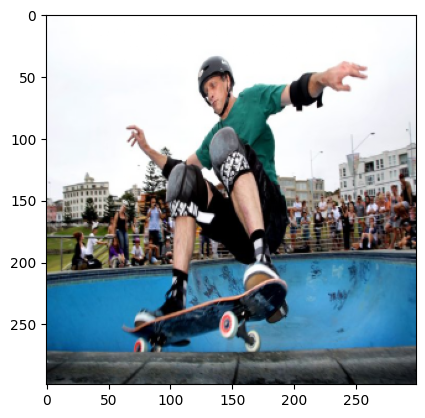

a man riding a skateboard down a ramp .
a man riding a skateboard on top of a ramp .
a man on a skateboard is doing a trick .
a man on a skateboard does a trick on a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard up the side of a ramp .
a man on a skateboard is doing a trick .
a man riding a skateboard on top of a ramp .
a man on a skateboard doing a trick on a ramp .


In [129]:
# !wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg 404(((
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299))

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

a man is holding a baseball bat .
a man with a hat and a hat and a hat and a little girl .
a man in a black shirt and a black shirt
a man in a suit and tie holding a baseball bat .
a man wearing a red shirt and a red tie
a man is holding a baseball bat .
a man is holding a baseball bat .
a man is holding a baseball bat .
a man is holding a baseball bat on a field .
a man is holding a baseball bat in his hand .


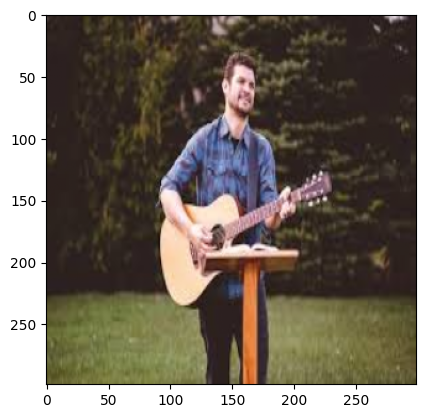

In [130]:
img = plt.imread('data/1.jpg')
img = resize(img, (299, 299))
plt.imshow(img)
for i in range(10):
  print(' '.join(generate_caption(img, t=5.)[1:-1]))

a cat is laying on a bed with a cat .
a cat laying on top of a bed .
a cat sitting on top of a blanket .
a cat is sleeping on a bed with a cat laying on it .
a cat laying on a bed with a cat on it .
a cat laying on top of a bed .
a cat is laying on a bed with a cat on it .
a cat laying on top of a bed with a cat on it .
a cat laying on top of a bed .
a cat laying on top of a bed .


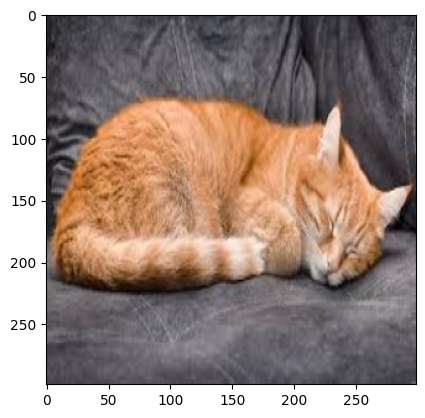

In [131]:
img = plt.imread('data/2.jpg')
img = resize(img, (299, 299))
plt.imshow(img)
for i in range(10):
  print(' '.join(generate_caption(img, t=5.)[1:-1]))

a pizza sitting on a table next to a glass of wine .
a pizza sitting on top of a table with a fork and knife .
a pizza sitting on top of a wooden table .
a pizza sitting on top of a wooden table .
a pizza sitting on top of a wooden table .
a pizza sitting on top of a table next to a plate of food .
a pizza with a pizza on it sitting on a table .
a pizza sitting on top of a table next to a glass of wine .
a pizza sitting on top of a table with a plate of food on it .
a pizza sitting on top of a table with a plate of food on it .


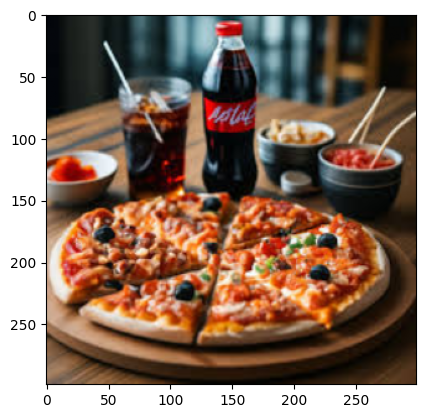

In [132]:
img = plt.imread('data/3.jpg')
img = resize(img, (299, 299))
plt.imshow(img)
for i in range(10):
  print(' '.join(
    generate_caption(img, t=5.)[1:-1]))

a group of people standing around a group of people .
a group of people standing around a group of people .
a group of people standing around a group of people .
a group of people standing around a group of people .
a group of people standing around a group of people .
a group of people standing around a group of people .
a group of people standing in a room .
a group of people are standing in a room .
a group of people standing around a group of people .
a group of people standing around a group of people .


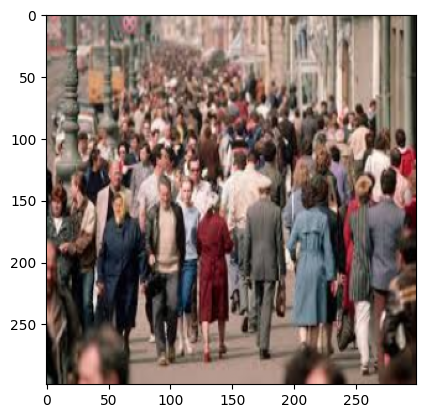

In [133]:
img = plt.imread('data/4.jpg')
img = resize(img, (299, 299))
plt.imshow(img)
for i in range(10):
  print(' '.join(generate_caption(img, t=5.)[1:-1]))

a bus driving down a street next to a city street .
a bus driving down a street next to a building .
a bus driving down a street next to a building .
a bus is driving down the street with a city in the background .
a bus driving down a street next to a building .
a bus driving down a city street with a city street in the background .
a bus driving down a street next to a city street .
a bus driving down a street next to a building .
a bus driving down a street next to a building .
a bus driving down a street next to a city .


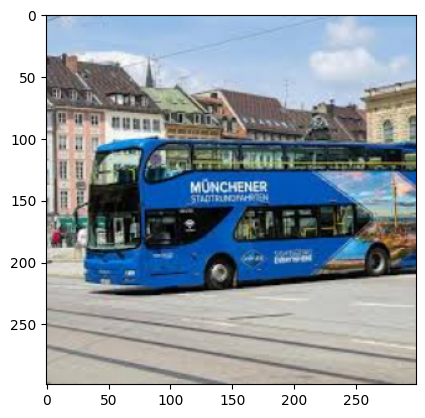

In [134]:
img = plt.imread('data/5.jpg')
img = resize(img, (299, 299))
plt.imshow(img)
for i in range(10):
  print(' '.join(generate_caption(img, t=5.)[1:-1]))

a group of people playing soccer on a field .
a group of children playing soccer on a field .
a group of people are playing soccer on a field .
a group of people playing soccer on a field .
a group of people standing in a field playing soccer .
a group of people playing soccer on a field .
a group of people playing soccer on a field .
a group of people on a field playing soccer .
a group of people in a field playing soccer .
a group of people are playing soccer on a field .


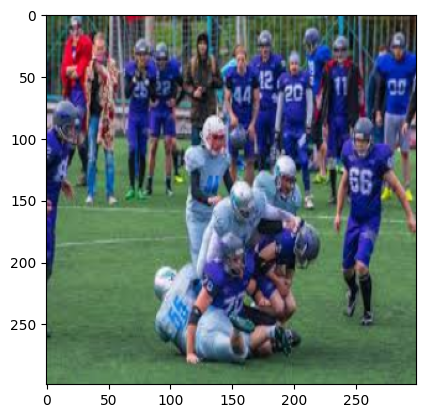

In [135]:
img = plt.imread('data/6.jpg')
img = resize(img, (299, 299))
plt.imshow(img)
for i in range(10):
  print(' '.join(generate_caption(img, t=5.)[1:-1]))

a bedroom with a bed and a window
a bedroom with a bed and a window
a bed with a white comforter and a white comforter .
a bedroom with a bed and a window
a bedroom with a bed and a window
a bedroom with a bed and a window .
a bedroom with a bed and a window
a bedroom with a bed and a window .
a bedroom with a bed and a window
a bedroom with a bed and a window


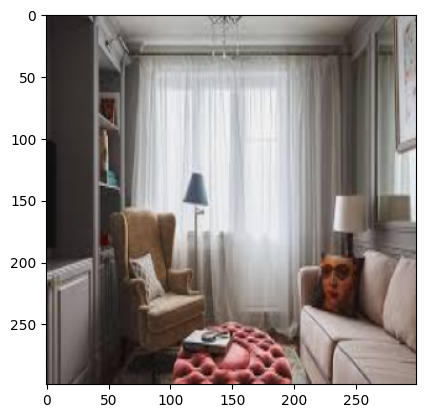

In [136]:
img = plt.imread('data/7.jpg')
img = resize(img, (299, 299))
plt.imshow(img)
for i in range(10):
  print(' '.join(generate_caption(img, t=5.)[1:-1]))

a large white and blue colored red and white cat .
a large white and blue colored red and white cat .
a large white and blue colored yellow and blue colored red and white cat .
a close up of a person holding a banana
a large white and blue colored yellow and blue striped and white cat .
a large white and blue colored red and white cat
a large brown and yellow banana in a field .
a large yellow and blue colored red and white cat .
a large white and red banana in a field .
a large yellow and blue bowl with a bunch of bananas .


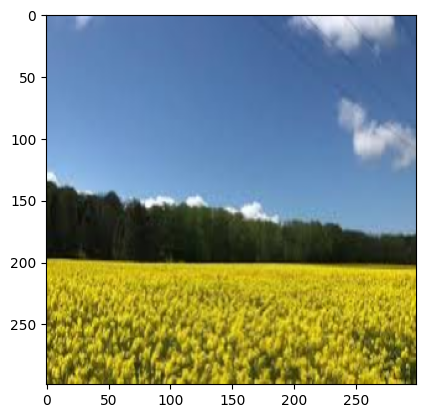

In [137]:
img = plt.imread('data/8.jpg')
img = resize(img, (299, 299))
plt.imshow(img)
for i in range(10):
  print(' '.join(generate_caption(img, t=5.)[1:-1]))

a person is working on a laptop computer .
a person is holding a large remote control
a person is holding a large piece of luggage .
a person is sitting on a bench with a laptop .
a man sitting on a bench with a dog on it .
a person is sitting on a bench in a room .
a person is holding a remote control at a table .
a person is holding a remote control on a table .
a person is sitting on a bench with a laptop .
a person is sitting on a wooden bench .


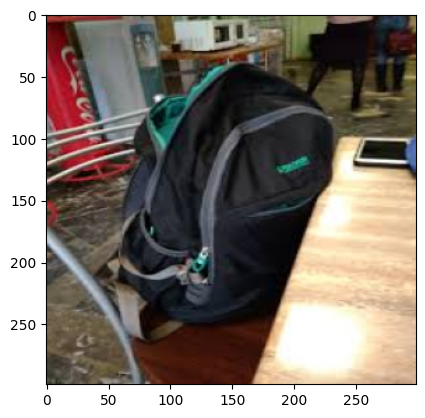

In [138]:
img = plt.imread('data/9.jpg')
img = resize(img, (299, 299))
plt.imshow(img)
for i in range(10):
  print(' '.join(generate_caption(img, t=5.)[1:-1]))

a group of people sitting at a table with a cake .
a group of people sitting at a table with a cake
a group of people sitting at a table with a cake .
a group of people sitting at a table with a cake .
a group of people sitting around a table with wine glasses .
a group of people sitting at a table with a cake
a group of people sitting at a table with a cake .
a group of people sitting at a table with a cake
a group of people sitting at a table with a cake .
a group of people sitting at a table with a cake .


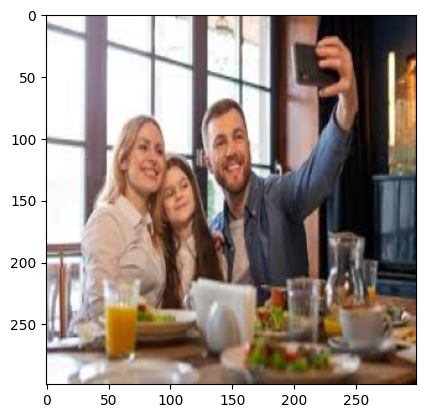

In [139]:
img = plt.imread('data/10.jpg')
img = resize(img, (299, 299))
plt.imshow(img)
for i in range(10):
  print(' '.join(generate_caption(img, t=5.)[1:-1]))


![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

> Примечание: Это задание адаптировано по материалам курса "Deep Learning" (Skoltech).
